In [1]:
import netCDF4
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Concatenate, AveragePooling2D,GaussianNoise,MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_normal
from sklearn import preprocessing
from scipy.stats import pearsonr
import os
from tqdm import tqdm_notebook
from sklearn.metrics import max_error,mean_absolute_error
import pysolar as ps
import datetime as dt
import pvlib

import warnings
warnings.filterwarnings("ignore")

In [2]:
def radiation(latitude_deg,longitude_deg,elevation,y,m,d):
    
    base = dt.datetime(y[0],m[0],d[0],1)
    times_index = [base + dt.timedelta(hours=x) for x in range(24*len(d))]
    times_index = pd.DatetimeIndex(times_index)
    
    sand_point = pvlib.location.Location(latitude,longitude, tz='UTC',altitude=elevation)

    solpos = pvlib.solarposition.get_solarposition(times_index, sand_point.latitude, sand_point.longitude)

    dni_extra = pvlib.irradiance.extraradiation(times_index)
    dni_extra = pd.Series(dni_extra, index=times_index)

    airmass_rel = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])
    airmass_abs = pvlib.atmosphere.absoluteairmass(airmass_rel)

    linke_turbidity=pvlib.clearsky.lookup_linke_turbidity(times_index, latitude=latitude, longitude=longitude, filepath=None, interp_turbidity=True)
    tmy_data=pvlib.clearsky.ineichen(solpos['apparent_zenith'], airmass_abs, linke_turbidity=linke_turbidity, altitude=elevation, dni_extra=dni_extra)
    tmy_data['day'] = tmy_data.index
    tmy_data['day'] = tmy_data['day'].apply(lambda x:x.strftime('%Y-%m-%d'))
    tmy_data = tmy_data.groupby('day').sum()
    
    return(tmy_data.values)

In [3]:
def create_model(shape_1,shape_2):
    
    input_shape_1 = (shape_1[2],shape_1[3],shape_1[4])
    inputs = list([])
    k = list([])
    var = ['apcp_sfc','dlwrf_sfc','dswrf_sfc','pres_msl','pwat_eatm','spfh_2m','tcdc_eatm','tcolc_eatm',
            'tmax_2m','tmin_2m','tmp_2m','tmp_sfc','ulwrf_sfc','ulwrf_tatm','uswrf_sfc']
    for v in var:
        a1 = Input(shape=input_shape_1,name='{}_input'.format(v))
        inputs.append(a1)
        #a2 = Conv3D( filters=16,kernel_size=(1,2,2),activation='relu',input_shape=(input_shape))(a1)
        a2 = Conv2D(filters=16,kernel_size=(3),activation='relu',kernel_initializer=glorot_normal())(a1)
        a2_noise = GaussianNoise(0.2)(a2)
        #a2_pool= AveragePooling3D(1,1)(a2_noise)
        a2_pool= AveragePooling2D((2))(a2_noise)
        a3 = Conv2D( filters=32,kernel_size=(1,2),activation='relu',kernel_initializer=glorot_normal())(a2_pool)
        #a3 = Conv3D( filters=32,kernel_size=(1,1,2),activation='relu',input_shape=(input_shape))(a2_pool)
        a4 = Flatten()(a3)
        a5 = Dense(100,activation='relu',kernel_initializer=glorot_normal())(a4)
        a6 = Dense(50,activation='relu',kernel_initializer=glorot_normal())(a5)
        k.append(a6)
    
    b1 = Input(shape=(shape_2[1],),name='aux_input')
    
    l= Concatenate()(k)
    m1 = Dense(100,activation='relu',kernel_initializer=glorot_normal())(l)
    m2 = Dense(50,activation='relu',kernel_initializer=glorot_normal())(m1)
    
    
    l1= Concatenate()([m2,b1])
    l2 = Dense(20,activation='relu',kernel_initializer=glorot_normal())(l1)
    out = Dense(1,activation='linear',kernel_initializer=glorot_normal())(l2)

    
    model = Model(inputs=[inputs,b1], outputs=out)
    model.compile('Adam',loss='mean_absolute_error',metrics=['mae'])
    return(model)


class StackingAverageModels():
    
    def __init__(self,shape_1,shape_2):
        self.base_models = [create_model(shape_1,shape_2) for _ in range(11)]
        self.histories = []
    
    def fit(self,X_train,h_train,y_train,X_test,h_test,y_test):
        for k,model in tqdm_notebook(enumerate(self.base_models)):
            x_train = X_train[k].copy()
            x_train.append(h_train)
            x_test = X_test[k].copy()
            x_test.append(h_test)
            history = model.fit(x_train,y_train,epochs=25,batch_size=25,validation_data=(x_test,y_test),verbose=0)
            self.histories.append(history)
            
    def predict(self,X,h):
        s = []
        for k,model in enumerate(self.base_models):
            x = X[k].copy()
            x.append(h)
            pred = model.predict(x)
            pred[pred<0] = 0
            s.append(pred)
            
        return(np.sum(s,axis=0)/len(self.base_models))

In [4]:
max_value = 4*(10**7)
    
df = pd.read_csv('ams-2014-solar-energy-prediction-contest/station_info.csv')
df_target = pd.read_csv('ams-2014-solar-energy-prediction-contest/train.csv')

In [5]:
dates = df_target['Date'].values
year = np.array(list(map(lambda x:int(str(x)[:4]),dates)))
month = np.array(list(map(lambda x:int(str(x)[4:6]),dates)))
months = month/12
day = np.array(list(map(lambda x:int(str(x)[6:]),dates)))

train_index = np.argwhere(year<=2004).flatten()
test_index = np.argwhere(year>2004).flatten() 


df_pred = pd.read_csv('ams-2014-solar-energy-prediction-contest/sampleSubmission.csv')
cols = df_pred.columns    

dates_pred = df_pred['Date'].values
year_pred = np.array(list(map(lambda x:int(str(x)[:4]),dates_pred)))
month_pred = np.array(list(map(lambda x:int(str(x)[4:6]),dates_pred)))
months_pred = month_pred/12
day_pred = np.array(list(map(lambda x:int(str(x)[6:]),dates_pred)))

hours = np.array(list(range(0,24)))

In [6]:
# df_final = pd.DataFrame(columns=cols)
# df_final['Date'] = dates_pred

In [7]:
print()
print('Loading x_values......')
print()


directory = np.sort(os.listdir("ams-2014-solar-energy-prediction-contest/train/"))
method_dataset = []

scaler_data = [preprocessing.MinMaxScaler() for _ in range(len(directory))]


Loading x_values......



In [8]:
print('training_data......')
print()


for method in tqdm_notebook(range(11)):

    dataset = []
    for k,file in enumerate(directory):
        nc_fid = netCDF4.Dataset("ams-2014-solar-energy-prediction-contest/train/{}".format(file),'r')
        var = list(nc_fid.variables.keys())[-1]
        data = np.array(nc_fid.variables[var][:])
        data = data[:,method,:,:,:]
        data = data.reshape(data.shape[0],data.shape[1],data.shape[2],data.shape[3])
        #data = scaling(data)
        #########
        nsamples, n_1,n_2,n_3 = data.shape
        data = data.flatten().reshape((nsamples,n_1*n_2*n_3))
        if method == 0:
            scaler_data[k].fit(data)
        data = scaler_data[k].transform(data)
        data = data.flatten().reshape((nsamples,n_1,n_2,n_3))
        ########
        data = np.array(data.reshape(-1,data.shape[1],data.shape[2],data.shape[3]))
        dataset.append(data)

    method_dataset.append(dataset)

training_data......



In [9]:
print('prediction data......')
print()

directory_2 = np.sort(os.listdir("ams-2014-solar-energy-prediction-contest/test/"))
method_pred_dataset = []

for method in tqdm_notebook(range(11)):

    dataset = []
    for k,file in enumerate(directory_2):
        nc_fid = netCDF4.Dataset("ams-2014-solar-energy-prediction-contest/test/{}".format(file),'r')
        var = list(nc_fid.variables.keys())[-1]
        data = np.array(nc_fid.variables[var][:])
        data = data[:,method,:,:,:]
        data = data.reshape(data.shape[0],data.shape[1],data.shape[2],data.shape[3])
        #data = scaling(data)
        ###########
        nsamples, n_1,n_2,n_3 = data.shape
        data = data.flatten().reshape((nsamples,n_1*n_2*n_3))
        data = scaler_data[k].transform(data)
        data = data.flatten().reshape((nsamples,n_1,n_2,n_3))
        ############
        data = np.array(data.reshape(-1,data.shape[1],data.shape[2],data.shape[3]))
        dataset.append(data)

    method_pred_dataset.append(dataset)


method_train_dataset = [[var[[train_index]].reshape(len(train_index),5,9,16) for var in model] for model in method_dataset]
method_test_dataset = [[var[[test_index]].reshape(len(test_index),5,9,16) for var in model] for model in method_dataset]
shape_1 = np.array(method_train_dataset[0]).shape   

######################################################        
offset = 0
stations = 1

prediction data......



In [10]:
for station in tqdm_notebook(df['stid'].values[offset:stations]):

    print()
    print('STATION: {}'.format(station))
    print()

    latitude = df[df['stid']==station]['nlat'].values[0]
    longitude = df[df['stid']==station]['elon'].values[0]
    elevation = df[df['stid']==station]['elev'].values[0]


    target = np.array(df_target[station].values)/max_value
    #scaler = preprocessing.MinMaxScaler()
    #scaler.fit(target.reshape((target.shape[0],-1)))
    #target = scaler.transform(target.reshape((target.shape[0],-1)))

    print('Loading h_values.......')
    print()



    rad = radiation(latitude,longitude,elevation,year,month,day)
    rad = np.array(rad)/10000
    #scaler_2 = preprocessing.MinMaxScaler()
    #rad = scaler_2.fit_transform(rad)


    y_train,y_test = target[train_index],target[test_index]
    h_train,h_test = np.array(list(zip(months[train_index],rad[train_index]))),np.array(list(zip(months[test_index],rad[test_index])))

    r = [[x for x in h[1]] for h in h_train]
    for i in range(len(r)):
        r[i].append(h_train[i][0])
    h_train = np.array(r)

    r = [[x for x in h[1]] for h in h_test]
    for i in range(len(r)):
        r[i].append(h_test[i][0])
    h_test = np.array(r)

    shape_2 = np.array(h_test).shape

    print('training CNN........')
    print()

    stacked_averaged_models = StackingAverageModels(shape_1,shape_2)
    stacked_averaged_models.fit(method_train_dataset,h_train,y_train,method_test_dataset,h_test,y_test)

    #y = y_test[:,0]
    y = y_test
    predicted = stacked_averaged_models.predict(method_test_dataset,h_test)[:,0]

    print('MAE: {}'.format(mean_absolute_error(predicted,y)))
    print()


    print('Calculating final predictions........')
    print()

    rad_pred = radiation(latitude,longitude,elevation,year_pred,month_pred,day_pred)
    rad_pred = np.array(rad_pred)/10000
    #scaler_2 = preprocessing.MinMaxScaler()
    #rad_pred = scaler_2.fit_transform(rad)


    h_pred = np.array(list(zip(months_pred,rad_pred)))
    r = [[x for x in h[1]] for h in h_pred]
    for i in range(len(r)):
        r[i].append(h_pred[i][0])
    h_pred = np.array(r)


    final_predicted = stacked_averaged_models.predict(method_pred_dataset,h_pred)[:,0]
    #final_predicted = scaler.inverse_transform(final_predicted.reshape(final_predicted.shape[0],-1))
    #df_final[station] = final_predicted*max_value
    #df_final.to_csv('submission.csv',index=False)
        
    #del stacked_averaged_models
    #del scaler

#df_final.to_csv('submission.csv',index=False)



STATION: ACME

Loading h_values.......

training CNN........



MAE: 0.04983903711485327

Calculating final predictions........



NameError: name 'df_final' is not defined

In [11]:
final_predicted_real = final_predicted*max_value

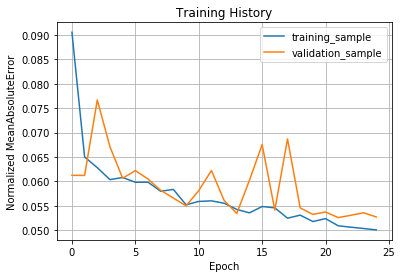

In [12]:
h = stacked_averaged_models.histories[1]
plt.plot(h.history['mae'],label='training_sample')
plt.plot(h.history['val_mae'],label='validation_sample')
plt.ylabel('Normalized MeanAbsoluteError')
plt.xlabel('Epoch')
plt.title('Training History')
plt.grid()
plt.legend()
plt.show()

In [13]:
y_test = y_test
y_train = y_train
predicted_test = stacked_averaged_models.predict(method_test_dataset,h_test)[:,0]
predicted_train = stacked_averaged_models.predict(method_train_dataset,h_train)[:,0]

In [14]:
r_train = pearsonr(y_train,predicted_train)[0]
r_test = pearsonr(y_test,predicted_test)[0]

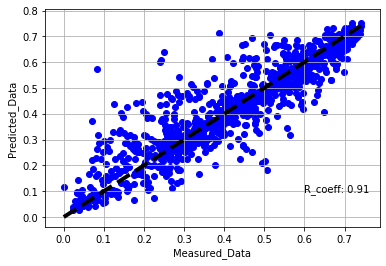

In [15]:
#fig, ax = plt.subplots()
plt.scatter(y_test, predicted_test,c='b')
#plt.scatter(y_train, predicted_train,'b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Measured_Data')
plt.ylabel('Predicted_Data')
plt.grid()
plt.text(0.6,0.1, "R_coeff: {}".format(round(r_test,2))) 
plt.show()

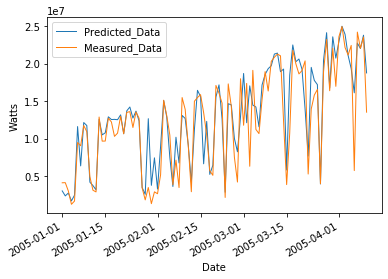

In [16]:
x = [dt.datetime(year[test_index[0]],month[test_index[0]],day[test_index[0]]) + dt.timedelta(days=i) for i in range(100)]
plt.plot(x,predicted[:100]*max_value,linewidth=1,label='Predicted_Data')
plt.plot(x,y[:100]*max_value,linewidth=1,label='Measured_Data')
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Watts')
plt.legend()